## ART Black Box Attack on Tesseract

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

%matplotlib inline

import numpy as np
import imageio
import visvis as vv
from matplotlib import pyplot as plt
from IPython.display import clear_output
import os 

from art import config
from art.estimators.classification import BlackBoxClassifier
from art.defences.preprocessor import JpegCompression
from art.attacks.evasion import HopSkipJump
from art.attacks.evasion import ZooAttack
from art.utils import to_categorical
from art.utils import load_dataset, get_file, compute_accuracy

### Make predictions

In [2]:
# read in images
image_target = imageio.imread(os.path.join(os.path.dirname(os.getcwd()), 'utils/data/tesseract', 'dissent.png'))
image_init = imageio.imread(os.path.join(os.path.dirname(os.getcwd()), 'utils/data/tesseract', 'assent.png'))

In [3]:
# predict function to call tesseract from the command line and convert
# its output to a one-hot encoding
def predict(x):
    
    out_label = []
    
    for x_i in x:
        # save image as intermediate png
        imageio.imsave('tmp.png', x_i.astype(np.uint8))

        # run tesseract
        status = os.system("tesseract tmp.png out")
        if status != 0:
            raise Exception('Tesseract failed to run.')

        # read text
        file = open("out.txt","r+") 
        test = file.read()
        out_string = test.strip()

        # convert to categorical
        if out_string == 'dissent':
            out_label.append(0)
        elif out_string == 'assent':
            out_label.append(1)
        else: 
            out_label.append(2)
    
    return to_categorical(out_label, 3)

# init black box object
classifier = BlackBoxClassifier(predict, image_target.shape, 3, clip_values=(0, 255))

In [4]:
label_dict = {0: 'dissent', 1: 'assent', 2: 'other'}

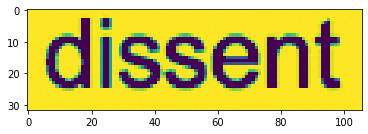

Tesseract output is: dissent


In [5]:
# this is the image we want to target
plt.imshow(image_target)
plt.show()
print('Tesseract output is: ' + label_dict[np.argmax(classifier.predict(np.array([image_target], dtype=np.float32)))])

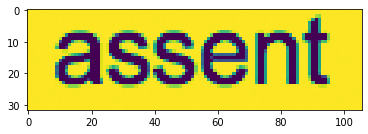

Tesseract output is: assent


In [6]:
# this is the label we want to perturb to
plt.imshow(image_init)
plt.show()
print('Tesseract output is: ' + label_dict[np.argmax(classifier.predict(np.array([image_init], dtype=np.float32)))])

### Attack using HopSkipJump

Adversarial image at step 0. L2 error 7213.825 and Tesseract output assent.


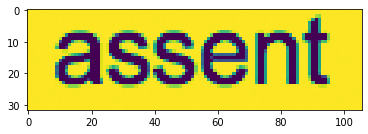

Adversarial image at step 30. L2 error 4220.758 and Tesseract output assent.


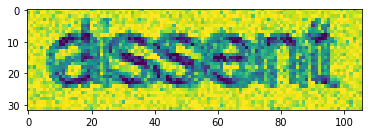

Adversarial image at step 60. L2 error 3997.406 and Tesseract output assent.


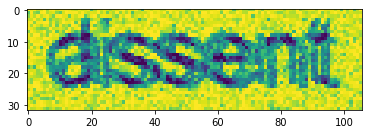

Adversarial image at step 90. L2 error 3947.9297 and Tesseract output assent.


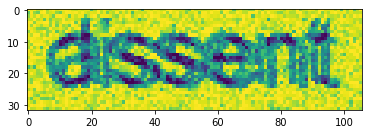

Adversarial image at step 120. L2 error 3922.5515 and Tesseract output assent.


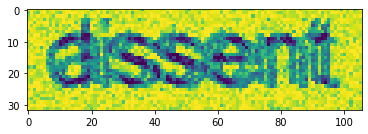

Adversarial image at step 150. L2 error 3794.534 and Tesseract output assent.


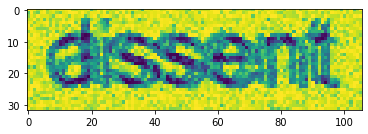

In [7]:
attack = HopSkipJump(classifier=classifier, targeted=True, norm=2, max_iter=0, max_eval=1000, init_eval=10)
iter_step = 10
x_adv = np.array([image_init], dtype=np.float32)
for i in range(16):
    x_adv = attack.generate(x=np.array([image_target], dtype=np.float32), x_adv_init=x_adv, y=to_categorical([1], 3))

    #clear_output()
    if i%3 == 0:
        print("Adversarial image at step %d." % (i * iter_step), "L2 error", 
              np.linalg.norm(np.reshape(x_adv[0] - image_target, [-1])),
              "and Tesseract output %s." % label_dict[np.argmax(classifier.predict(x_adv)[0])])
        plt.imshow(x_adv[0])
        plt.show(block=False)

    attack.max_iter = iter_step

### Defend Classifier Using Jpeg Compression

In [9]:
jpeg = JpegCompression(clip_values=(0, 255), channels_first=False)
classifier_def = BlackBoxClassifier(predict, image_target.shape, 3, clip_values=(0, 255),
                                    preprocessing_defences=[jpeg])

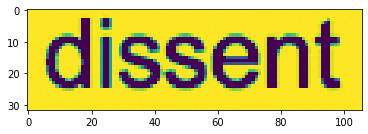

Tesseract output is: dissent


In [11]:
# this is the image we want to target
plt.imshow(image_target)
plt.show()
print('Tesseract output is: ' + label_dict[np.argmax(classifier_def.predict(np.array([image_target], dtype=np.float32)))])

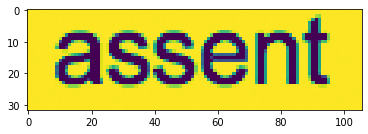

Tesseract output is: assent


In [12]:
# this is the label we want to perturb to
plt.imshow(image_init)
plt.show()
print('Tesseract output is: ' + label_dict[np.argmax(classifier_def.predict(np.array([image_init], dtype=np.float32)))])

### Attack Defended Classifier Using HopSkipJump

Adversarial image at step 0. L2 error 7213.825 and Tesseract output assent.


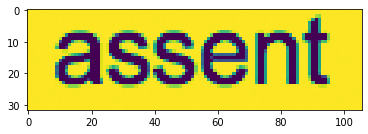

Adversarial image at step 30. L2 error 4201.479 and Tesseract output assent.


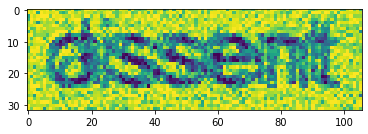

Adversarial image at step 60. L2 error 3841.222 and Tesseract output assent.


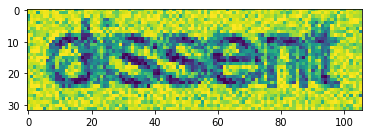

Adversarial image at step 90. L2 error 3598.9988 and Tesseract output assent.


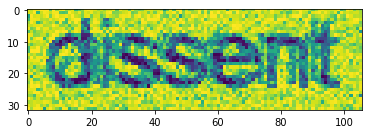

Adversarial image at step 120. L2 error 3490.935 and Tesseract output assent.


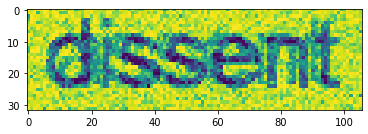

Adversarial image at step 150. L2 error 3354.4868 and Tesseract output assent.


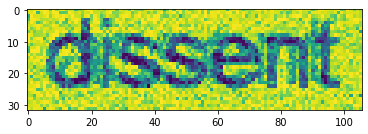

In [15]:
attack = HopSkipJump(classifier=classifier_def, targeted=True, norm=2, max_iter=0, max_eval=1000, init_eval=10)
iter_step = 10
x_adv = np.array([image_init], dtype=np.float32)
for i in range(16):
    x_adv = attack.generate(x=np.array([image_target], dtype=np.float32), x_adv_init=x_adv, y=to_categorical([1], 3))

    #clear_output()
    if i%3 == 0:
        print("Adversarial image at step %d." % (i * iter_step), "L2 error", 
              np.linalg.norm(np.reshape(x_adv[0] - image_target, [-1])),
              "and Tesseract output %s." % label_dict[np.argmax(classifier_def.predict(x_adv)[0])])
        plt.imshow(x_adv[0])
        plt.show(block=False)

    attack.max_iter = iter_step